In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

In [29]:
total = pd.read_csv("../CSV/train_data.csv")
test = pd.read_csv("../CSV/pred_test.csv")

print("total shape : {}, test shape : {}".format(total.shape, test.shape))

total shape : (368088, 12), test shape : (15120, 12)


In [30]:
total.head(3)

,연월일,시간,일시,year,month,day,hour,weekday,구분,구분_int,공급량,기온(°C)
0,2013-01-01,1,2013-01-01 00:00:00,2013,1,1,0,1,A,0,2497.129,-8.3
1,2013-01-01,2,2013-01-01 01:00:00,2013,1,1,1,1,A,0,2363.265,-8.5
2,2013-01-01,3,2013-01-01 02:00:00,2013,1,1,2,1,A,0,2258.505,-8.4


In [31]:
test.head(3)

,일자|시간|구분,일자,시간,구분,구분_int,일시,year,month,day,hour,weekday,기온(°C)
0,2019-01-01 01 A,2019-01-01,1,A,0,2019-01-01 00:00:00,2019,1,1,0,1,-6.6
1,2019-01-01 02 A,2019-01-01,2,A,0,2019-01-01 01:00:00,2019,1,1,1,1,-6.7
2,2019-01-01 03 A,2019-01-01,3,A,0,2019-01-01 02:00:00,2019,1,1,2,1,-7.1


In [32]:
def nmae(true_df, pred_df):
    target_idx = true_df.iloc[:,0]
    pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
    true = true_df.iloc[:,1].to_numpy()
    pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [33]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

# "year", "month", "day", "hour", "weekday", "구분_int", "기온(°C)"
features = ["month", "hour", "구분_int", "기온(°C)"]
# features = ["year", "month", "day", "hour", "weekday", "구분_int", "기온(°C)"]
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

X = total[features]
y = total["공급량"]

In [34]:
grid_parameters = {"max_depth" : [12, 14, 16], 
                   "n_estimators" : [1000, 1500, 2000], 
                   "learning_rate" : [0.01, 0.05, 0.1]}

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

kfold = KFold(n_splits = 10, shuffle = True, random_state = 27)

model = lgb.LGBMRegressor(**params)
grid_search = GridSearchCV(model, param_grid = grid_parameters, cv = kfold, n_jobs = -1)
grid_search.fit(train_x, train_y)

print('GridSearchCV 최적 파라미터 : ', grid_search.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_search.best_score_))

# GridSearchCV 최적 파라미터 :  {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 1000}
# GridSearchCV 최고 정확도 : 0.9717

GridSearchCV 최적 파라미터 :  {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 1000}
GridSearchCV 최고 정확도 : 0.9717


In [35]:
grid_search.score(val_x, val_y)

0.9678120835217527

In [40]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 27)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42, 
    "learning_rate" : 0.05, 
    "max_depth" : 12, 
    "n_estimators" : 1000
}

evals = [(val_x, val_y)]

model = lgb.LGBMRegressor(**params)
model.fit(train_x, train_y, early_stopping_rounds = 10, eval_metric = "l2", eval_set = evals, verbose = 20)
# model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

pred = model.predict(val_x)

true_y = pd.DataFrame({"true_y" : val_y})
pred_y = pd.DataFrame({"pred_y" : pred})

true_y.reset_index(drop = True, inplace = True)
true_y.reset_index(inplace = True)
pred_y.reset_index(inplace = True)

cross_score = cross_val_score(model, X, y, cv = kfold)
cross_score_train = cross_val_score(model, train_x, train_y, cv = kfold)
cross_score_test = cross_val_score(model, val_x, val_y, cv = kfold)

print("학습용 데이터 결정계수: {:.3f}".format(model.score(train_x, train_y)))
print("테스트 데이터 결정계수: {:.3f}".format(model.score(val_x, val_y)))

print("MAE : {:.6f}".format(mean_absolute_error(val_y, pred)))
print("MSE : {:.6f}".format(mean_squared_error(val_y, pred)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(val_y, pred))))
print("NMAE : {:.6f}".format(nmae(true_y, pred_y)))

# print("교차 검증별 정확도:", cross_score)
print("전체 평균 검증 정확도 :", np.mean(cross_score))
print("train 평균 검증 정확도 :", np.mean(cross_score_train))
print("test 평균 검증 정확도 :", np.mean(cross_score_test))

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 234357	valid_0's l1: 339.018
[40]	valid_0's l2: 92082.3	valid_0's l1: 202.512
[60]	valid_0's l2: 57850.9	valid_0's l1: 155.698
[80]	valid_0's l2: 45540.8	valid_0's l1: 134.886
[100]	valid_0's l2: 39933.8	valid_0's l1: 125.438
[120]	valid_0's l2: 37062.9	valid_0's l1: 120.706
[140]	valid_0's l2: 35508.9	valid_0's l1: 118.201
[160]	valid_0's l2: 34660.3	valid_0's l1: 116.739
[180]	valid_0's l2: 34101.6	valid_0's l1: 115.755
[200]	valid_0's l2: 33790.8	valid_0's l1: 114.902
[220]	valid_0's l2: 33531.7	valid_0's l1: 114.298
[240]	valid_0's l2: 33360.1	valid_0's l1: 113.904
[260]	valid_0's l2: 33264.6	valid_0's l1: 113.555
[280]	valid_0's l2: 33147.2	valid_0's l1: 113.249
[300]	valid_0's l2: 33039.6	valid_0's l1: 112.93
[320]	valid_0's l2: 32977.7	valid_0's l1: 112.691
[340]	valid_0's l2: 32924.8	valid_0's l1: 112.475
[360]	valid_0's l2: 32885.6	valid_0's l1: 112.355
학습용 데이터 결정계수: 0.976
테스트 데이터 결정계수: 0.968
MAE : 112.359213
MSE : 32882.248588
RMSE : 181.334632
NMAE : 0.551

In [42]:
true_y.head(3)

,index,true_y
0,0,1765.008
1,1,1679.186
2,2,1610.885


In [43]:
pred_y.head(3)

,index,pred_y
0,0,1969.834364
1,1,1707.922198
2,2,1595.767577


In [8]:
submission = pd.read_csv('../CSV/가스공급량 수요예측 모델개발 data/sample_submission.csv')

In [9]:
test_x = test[features]
preds = model.predict(test_x)
submission['공급량'] = preds
# submission.to_csv("../CSV/Submission/08_lightgbm_model.csv", index = False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44592 missing from current font.
  

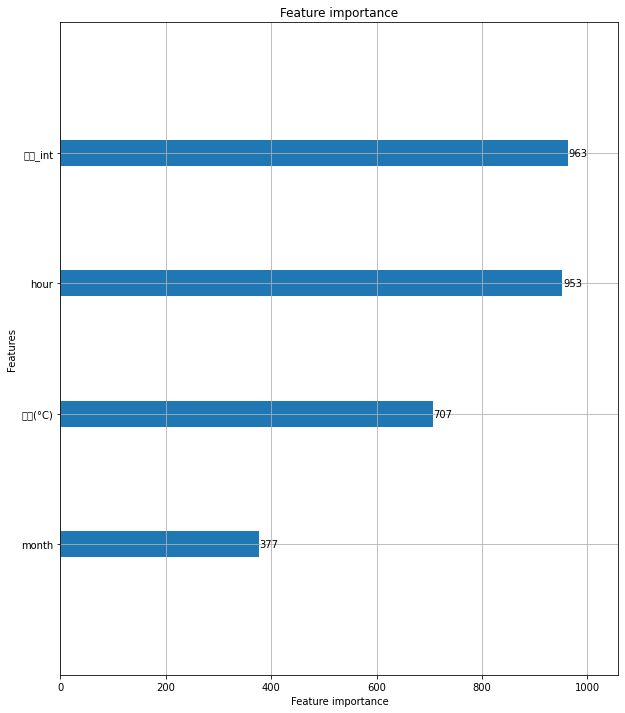

In [10]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax = ax)

In [11]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   연월일      368088 non-null  object 
 1   시간       368088 non-null  int64  
 2   일시       368088 non-null  object 
 3   year     368088 non-null  int64  
 4   month    368088 non-null  int64  
 5   day      368088 non-null  int64  
 6   hour     368088 non-null  int64  
 7   weekday  368088 non-null  int64  
 8   구분       368088 non-null  object 
 9   구분_int   368088 non-null  int64  
 10  공급량      368088 non-null  float64
 11  기온(°C)   368088 non-null  float64
dtypes: float64(2), int64(7), object(3)
memory usage: 33.7+ MB
